Loading Bank Account Fraud Dataset...
Dataset shape: (1000000, 32)
Total transactions: 1,000,000

Columns: ['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'employment_status', 'credit_risk_score', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

Target column: fraud_bool
Fraud cases: 11,029
Fraud rate: 1.10%

DATASET INFO

Data types:
fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months

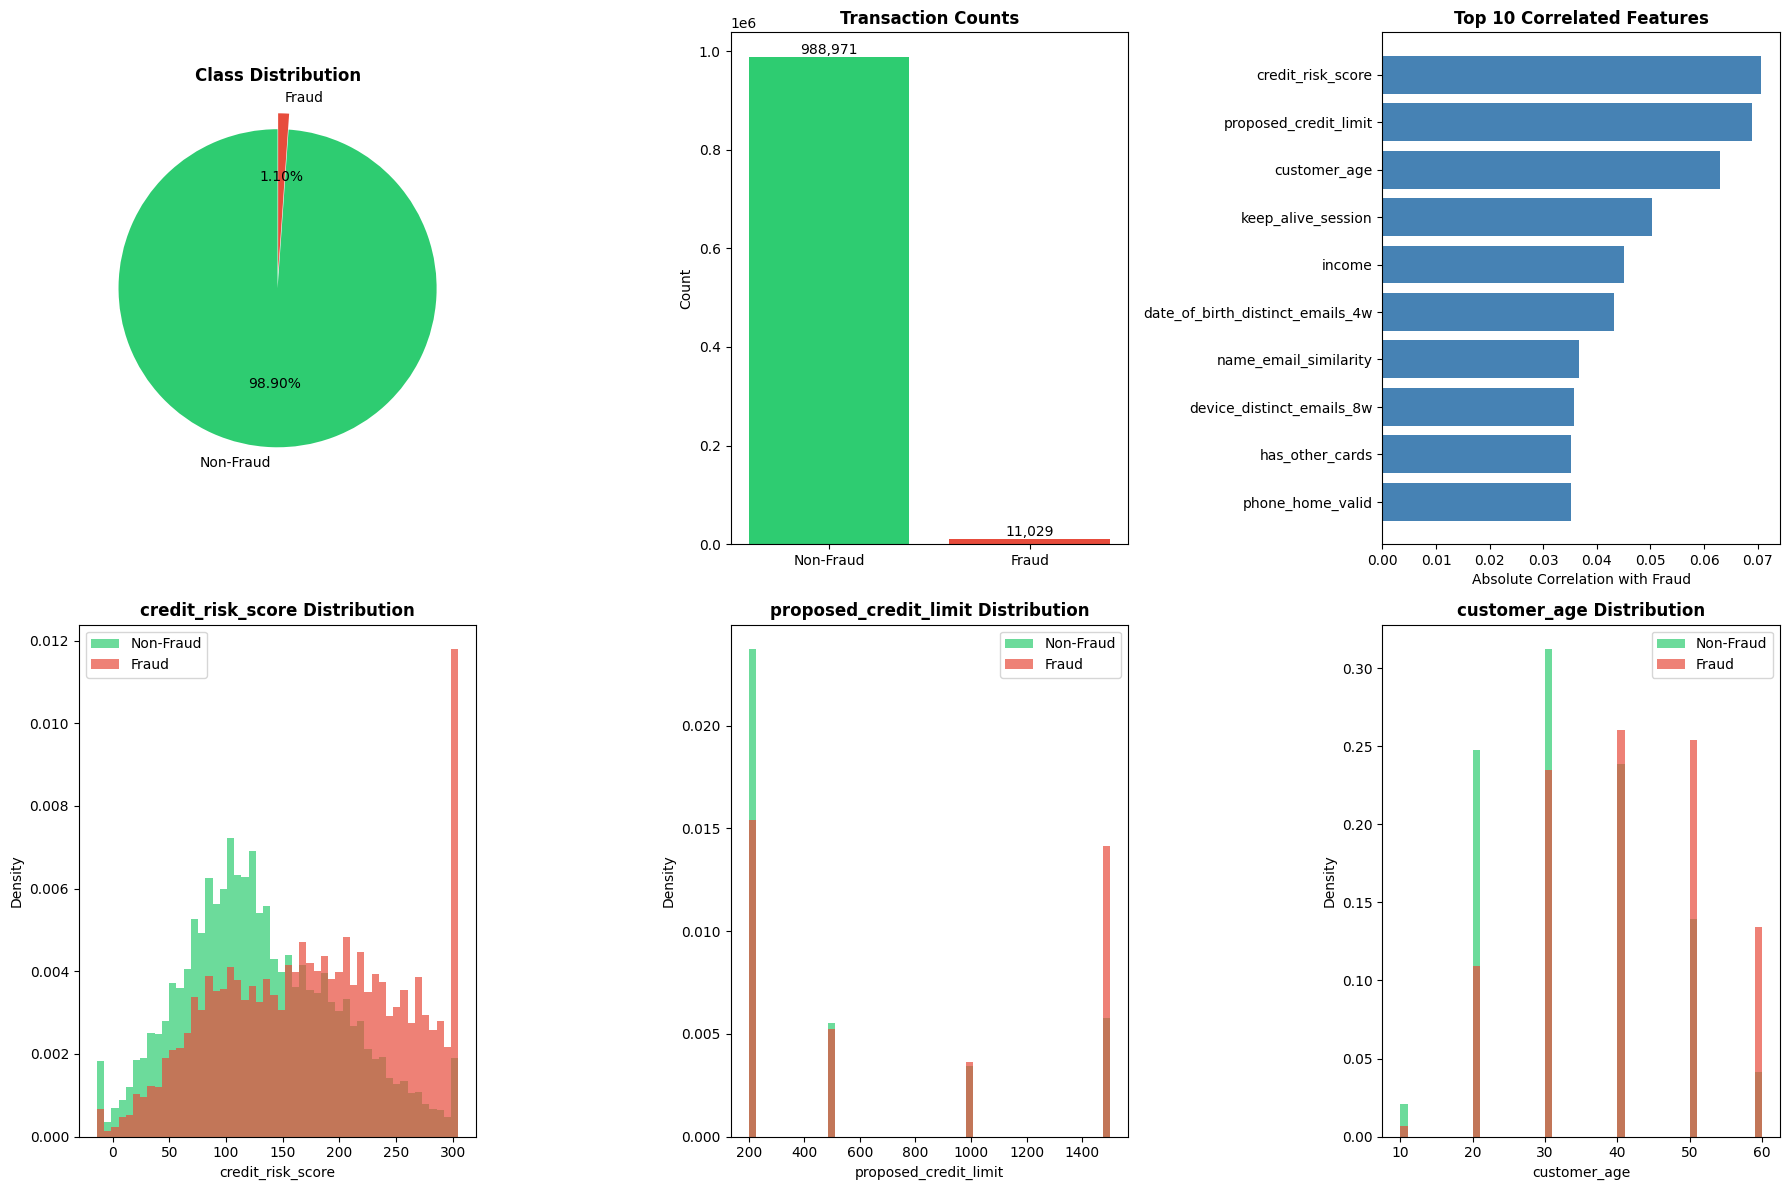


✓ EDA visualization saved: ../outputs/secondary/eda/eda_overview.png

EDA SUMMARY - SECONDARY DATASET (Bank Account Fraud)

Dataset: Bank Account Fraud (NeurIPS 2022)

Key Statistics:
- Total records: 1,000,000
- Fraud cases: 11,029 (1.10%)
- Non-fraud cases: 988,971 (98.90%)
- Features: 31
- Numeric features: 26
- Categorical features: 5
- Missing values: 0

Top Predictive Features (by correlation):
credit_risk_score        0.070624
proposed_credit_limit    0.068907
customer_age             0.062959
keep_alive_session       0.050296
income                   0.045079

Observations:
1. Class imbalance: 1.10% fraud rate
2. Strong correlations exist: 0.071 (top feature)
3. Mix of numeric and categorical features


✓ Target column 'fraud_bool' saved for model training


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ===== 1. LOAD DATA =====
print("Loading Bank Account Fraud Dataset...")
df = pd.read_csv('../data/secondary/Base.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total transactions: {len(df):,}")

# Check target column name
print(f"\nColumns: {df.columns.tolist()}")

# ===== 2. IDENTIFY TARGET COLUMN =====
# Common names: 'fraud', 'is_fraud', 'Class', 'fraud_bool', 'label'
possible_targets = ['fraud', 'is_fraud', 'Class', 'fraud_bool', 'label', 'target']
target_col = None

for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    print("\n⚠️ Target column not found. Checking for binary columns...")
    for col in df.columns:
        if df[col].nunique() == 2 and df[col].dtype in ['int64', 'int32', 'float64']:
            print(f"  Potential target: {col} - values: {df[col].unique()}")

print(f"\nTarget column: {target_col}")
print(f"Fraud cases: {df[target_col].sum():,}")
print(f"Fraud rate: {df[target_col].mean()*100:.2f}%")

# ===== 3. BASIC INFO =====
print("\n" + "="*60)
print("DATASET INFO")
print("="*60)
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")
if df.isnull().sum().sum() == 0:
    print("No missing values!")

# ===== 4. STATISTICAL SUMMARY =====
print("\n" + "="*60)
print("STATISTICAL SUMMARY (Numeric Columns)")
print("="*60)
print(df.describe())

# ===== 5. CLASS DISTRIBUTION =====
print("\n" + "="*60)
print("CLASS DISTRIBUTION")
print("="*60)
fraud_counts = df[target_col].value_counts()
print(f"Non-Fraud (0): {fraud_counts[0]:,} ({fraud_counts[0]/len(df)*100:.2f}%)")
print(f"Fraud (1):     {fraud_counts[1]:,} ({fraud_counts[1]/len(df)*100:.2f}%)")

# ===== 6. FEATURE ANALYSIS =====
print("\n" + "="*60)
print("FEATURE TYPES")
print("="*60)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

if categorical_cols:
    print(f"\nCategorical columns: {categorical_cols}")
    for col in categorical_cols[:5]:  # Show first 5
        print(f"  {col}: {df[col].nunique()} unique values")

# ===== 7. CORRELATION WITH TARGET =====
print("\n" + "="*60)
print("FEATURE CORRELATION WITH FRAUD (Top 15)")
print("="*60)

numeric_df = df.select_dtypes(include=[np.number])
correlations = numeric_df.corr()[target_col].drop(target_col).abs().sort_values(ascending=False)
print(correlations.head(15))

# ===== 8. VISUALIZATIONS =====
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Class Distribution (Pie)
axes[0, 0].pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%',
               colors=['#2ecc71', '#e74c3c'], startangle=90, explode=[0, 0.1])
axes[0, 0].set_title('Class Distribution', fontsize=12, fontweight='bold')

# Plot 2: Class Distribution (Bar)
axes[0, 1].bar(['Non-Fraud', 'Fraud'], fraud_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Transaction Counts', fontsize=12, fontweight='bold')
for i, v in enumerate(fraud_counts.values):
    axes[0, 1].text(i, v, f'{v:,}', ha='center', va='bottom')

# Plot 3: Top Correlated Features
top_corr = correlations.head(10)
axes[0, 2].barh(top_corr.index, top_corr.values, color='steelblue')
axes[0, 2].set_xlabel('Absolute Correlation with Fraud')
axes[0, 2].set_title('Top 10 Correlated Features', fontsize=12, fontweight='bold')
axes[0, 2].invert_yaxis()

# Plot 4-6: Distribution of top 3 correlated features
top_3_features = correlations.head(3).index.tolist()

for idx, feature in enumerate(top_3_features):
    ax = axes[1, idx]

    fraud_vals = df[df[target_col]==1][feature].dropna()
    nonfraud_vals = df[df[target_col]==0][feature].dropna()

    # Clip outliers for visualization
    upper = df[feature].quantile(0.99)
    lower = df[feature].quantile(0.01)

    ax.hist(nonfraud_vals.clip(lower, upper), bins=50, alpha=0.7, label='Non-Fraud', color='#2ecc71', density=True)
    ax.hist(fraud_vals.clip(lower, upper), bins=50, alpha=0.7, label='Fraud', color='#e74c3c', density=True)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/secondary/eda/eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ EDA visualization saved: ../outputs/secondary/eda/eda_overview.png")

# ===== 9. SUMMARY =====
print("\n" + "="*60)
print("EDA SUMMARY - SECONDARY DATASET (Bank Account Fraud)")
print("="*60)
print(f"""
Dataset: Bank Account Fraud (NeurIPS 2022)

Key Statistics:
- Total records: {len(df):,}
- Fraud cases: {df[target_col].sum():,} ({df[target_col].mean()*100:.2f}%)
- Non-fraud cases: {(df[target_col]==0).sum():,} ({(1-df[target_col].mean())*100:.2f}%)
- Features: {len(df.columns) - 1}
- Numeric features: {len(numeric_cols) - 1}
- Categorical features: {len(categorical_cols)}
- Missing values: {df.isnull().sum().sum()}

Top Predictive Features (by correlation):
{correlations.head(5).to_string()}

Observations:
1. Class imbalance: {df[target_col].mean()*100:.2f}% fraud rate
2. Strong correlations exist: {correlations.iloc[0]:.3f} (top feature)
3. Mix of numeric and categorical features
""")

# Save target column name for later use
with open('../models/secondary/target_col.txt', 'w') as f:
    f.write(target_col)
print(f"\n✓ Target column '{target_col}' saved for model training")